<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/forwardModels/neuralRepresentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Representation
## David Brady
## University of Arizona
## September 2023

### libraries

In [63]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.activations import gelu, elu, sigmoid, swish, relu
from tensorflow.keras.backend import get_value
import matplotlib.pyplot as plt
#from google.colab import files
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.special import j0
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size']= 22

## Activation functions and peceptrons

  A perceptron operates on a data array $\bf f$ according to $g=o({\bf w}\cdot{\bf f}+b)$, where $o(\cdot )$ is the activation function, ${\bf w}$ is a weight vector and $b$ is a bias value. In typical neural models, the activation function acts as threshold returning positive values above the threshold and zero below threshold. But activation functions may alternatively serve to return frequency or local responses as illustrated by the $\sin(x)$ and Bessel $j0(x)$ functions shown below.

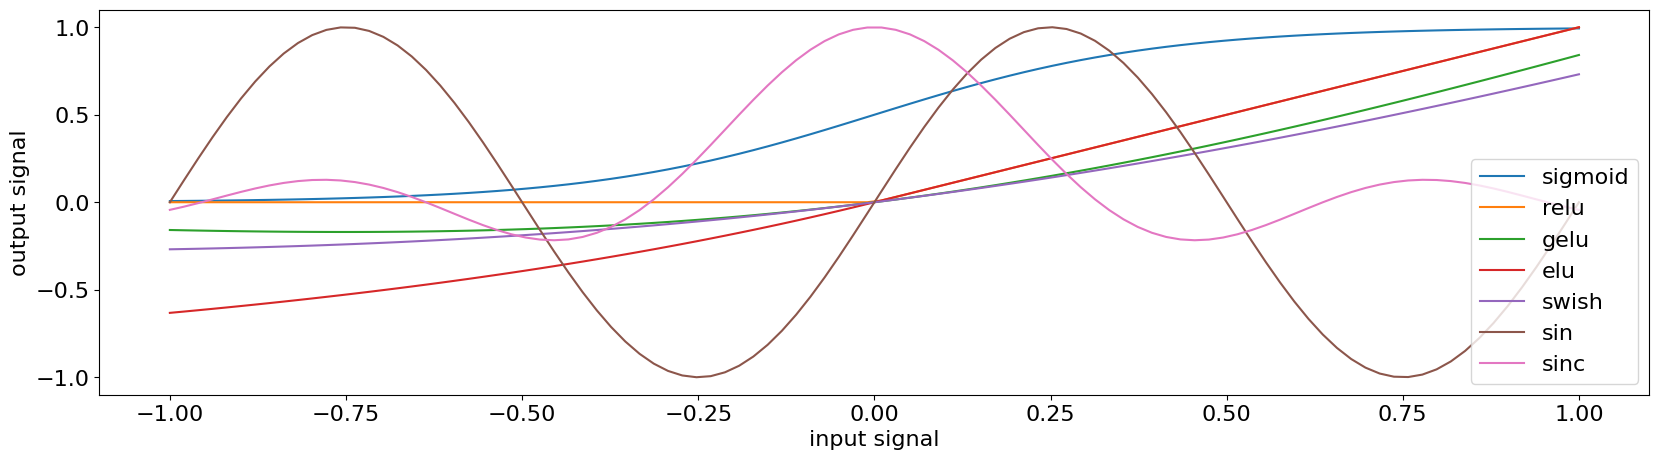

In [ ]:
#
# relu, sigmoid and softmax optimization functions
#
x=np.linspace(-1,1,100)
plt.plot(x,sigmoid(5*x),label='sigmoid')
plt.plot(x,relu(x),label='relu')
plt.plot(x,gelu(x),label='gelu')
plt.plot(x,elu(x),label='elu')
plt.plot(x,swish(x),label='swish')
plt.plot(x,np.sin(2*np.pi*x),label='sin')
plt.plot(x,np.sinc(np.pi*x),label='sinc')
plt.xlabel('input signal')
plt.ylabel('output signal')
plt.legend()
plt.savefig('activation.pdf')
#files.download('activation.pdf')

For ${\bf f}\in \mathbb{R}^2$, the  perceptron separates the 2D plane with a line. Here we suppose for example that
 $${\bf w}=\begin{bmatrix}0.5\\0.25\end{bmatrix}$$
 and $b=0.2$

In [51]:
def grelu(x,y, w, b):
    gv=get_value(relu([w[0]*x+w[1]*y+b]))
    return gv
def ggelu(x,y, w, b):
    gv=get_value(gelu([w[0]*x+w[1]*y+b]))
    return gv
def gsigmoid(x,y, w, b):
    gv=get_value(sigmoid([w[0]*x+w[1]*y+b]))
    return gv
def gsin(x,y, w, b):
    gv=np.sin(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gj0(x,y, w, b):
    gv=j0(2*np.pi*(w[0]*x+w[1]*y+b))
    return gv
def gSinc(x,y, w, b):
    gv=tf.experimental.numpy.sinc(np.pi*(w[0]*x+w[1]*y+b))
    return gv


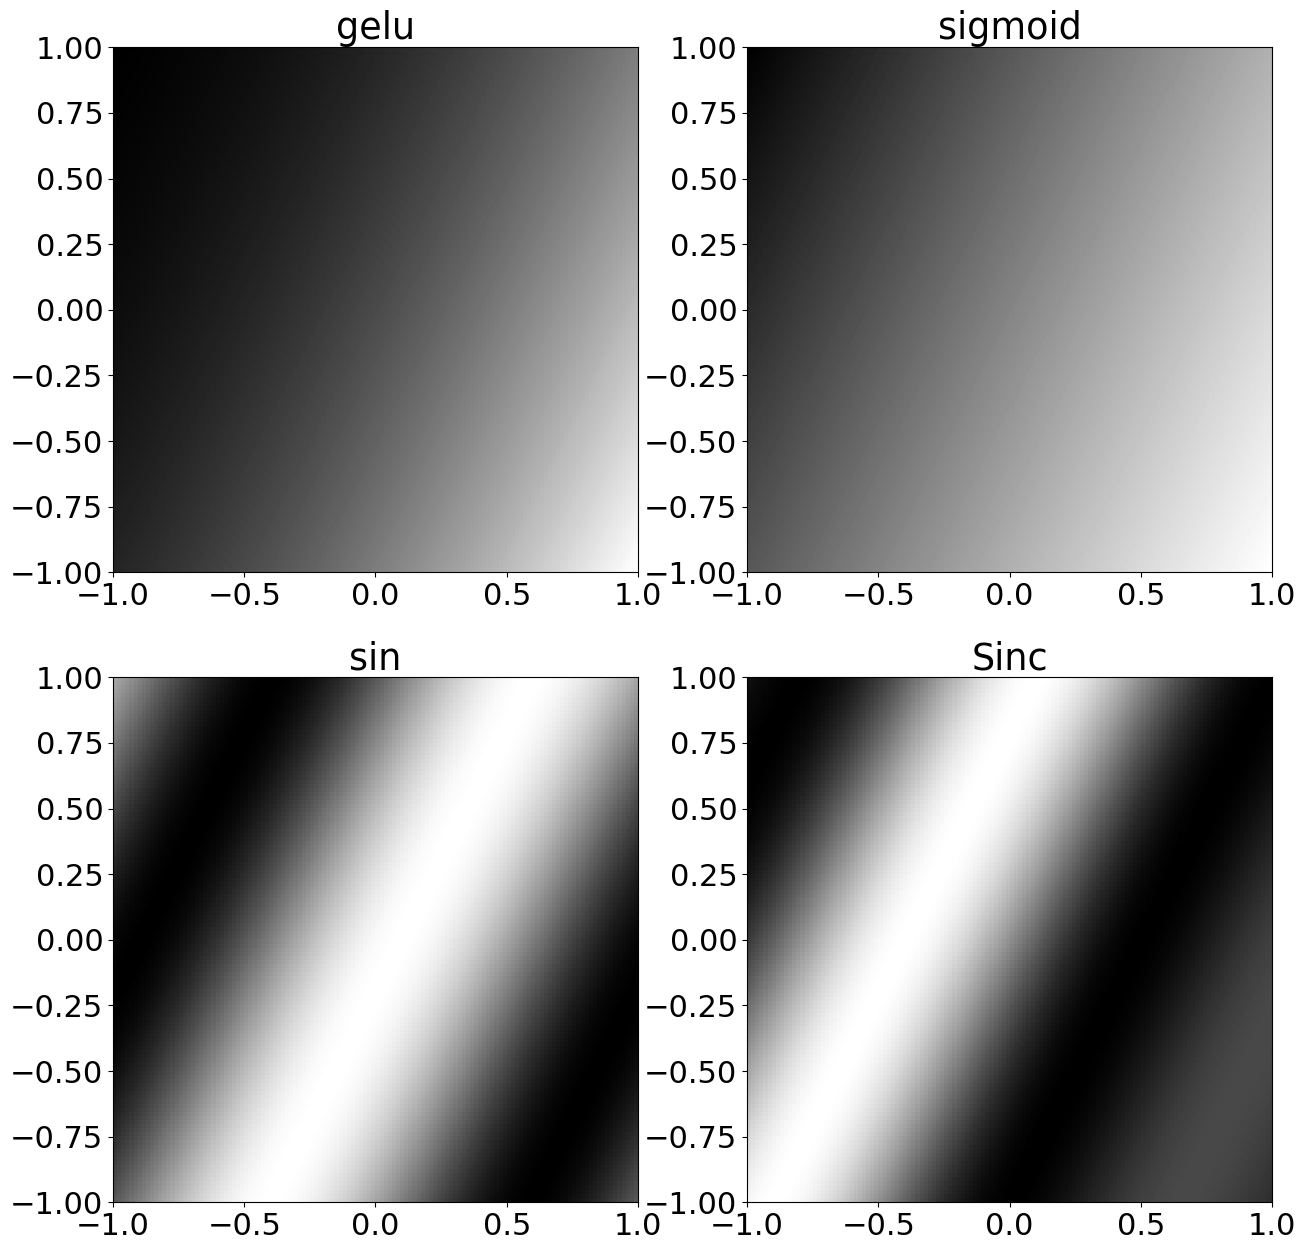

In [52]:
xRange=np.linspace(-1,1,128)
x,y=np.meshgrid(xRange,xRange)
w=[0.5,0.25]
b=0.2
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
pop=ggelu(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('gelu')
plt.subplot(2,2,2)
pop=gsigmoid(x,y,w,b)[0,:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sigmoid')
plt.subplot(2,2,3)
pop=gsin(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
pop=gSinc(x,y,w,b)[:,:]
plt.imshow(pop, extent=[-1,1,-1,1], cmap='gray')
plt.title('Sinc')
plt.savefig('2nodeSegmentation.pdf')

## Multilayer Perceptrons

A multilayer perceptron is a feedforward neural network  with an input layer, hidden layers and an output layer. MLP can be trained to implement arbitrary mappings between the input and output layers.

In [ ]:
coords=tf.stack((x,y))
coords=tf.reshape(coords,[2,-1])
coords=tf.transpose(coords)

In [ ]:
3*256+17*256+17*8+8*2

5272

In [ ]:
128*128

16384

In [ ]:
inputs=layers.Input(shape=( 2))
initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=15)
x1S=layers.Dense(256, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(inputs)
x2S=layers.Dense(16, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x1S)
x3S=layers.Dense(8, activation=tf.math.sin,kernel_initializer=initializer, trainable=False)(x2S)
x4S=layers.Dense(1, activation=tf.math.sin,kernel_initializer=initializer,trainable=False)(x3S)
mlpSin=Model(inputs,x4S)
x1G=layers.Dense(256, activation='gelu',kernel_initializer=initializer, trainable=False)(inputs)
x2G=layers.Dense(16, activation='gelu',kernel_initializer=initializer, trainable=False)(x1G)
x3G=layers.Dense(8, activation='gelu',kernel_initializer=initializer,trainable=False)(x2G)
x4G=layers.Dense(1, activation='gelu',kernel_initializer=initializer,trainable=False)(x3G)
mlpG=Model(inputs,x4G)
x1J=layers.Dense(256, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(inputs)
x2J=layers.Dense(16, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer, trainable=False)(x1J)
x3J=layers.Dense(8, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x2J)
x4J=layers.Dense(1, activation=tf.experimental.numpy.sinc,kernel_initializer=initializer,trainable=False)(x3J)
mlpJ=Model(inputs,x4J)


In [ ]:
mlpSimage=mlpSin.predict(coords)
mlpGimage=mlpG.predict(coords)
mlpJimage=mlpJ.predict(coords)

512/512 [==============================] - 0s 377us/step


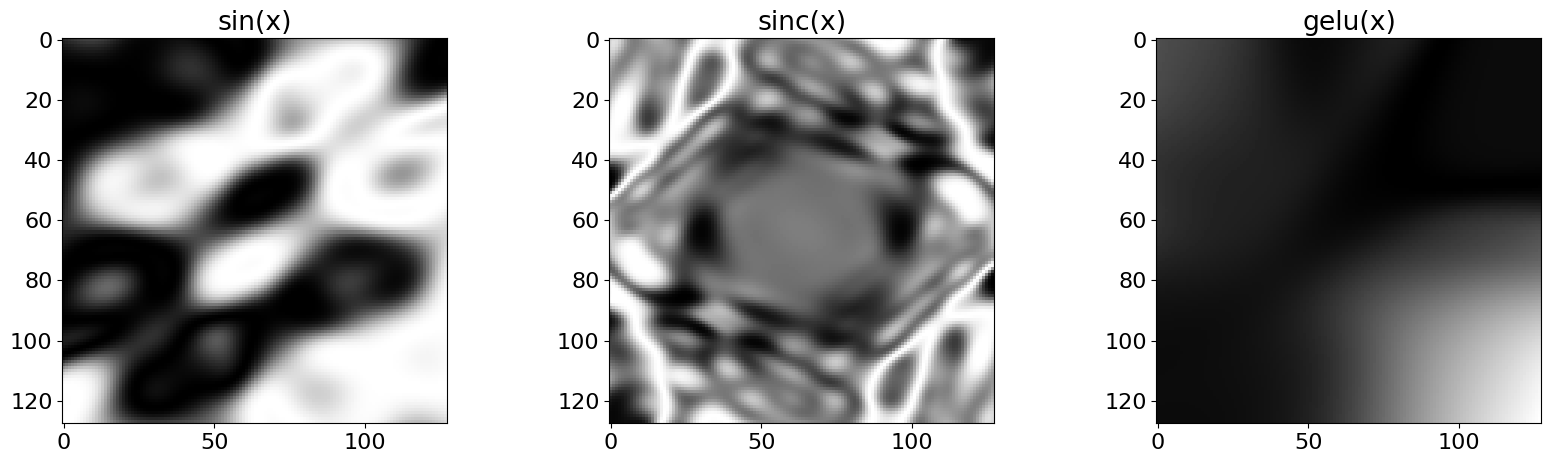

In [ ]:
plt.subplot(1,3,1)
plt.imshow(np.resize(mlpSimage,(128,128)),cmap='gray')
plt.title('sin(x)')
plt.subplot(1,3,2)
plt.imshow(np.resize(mlpJimage,(128,128)), cmap='gray')
plt.title('sinc(x)')
plt.subplot(1,3,3)
plt.imshow(np.resize(mlpGimage,(128,128)), cmap='gray')
plt.title('gelu(x)')
plt.savefig('mlpRandom.pdf')

## Learned neural representation

In [46]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()



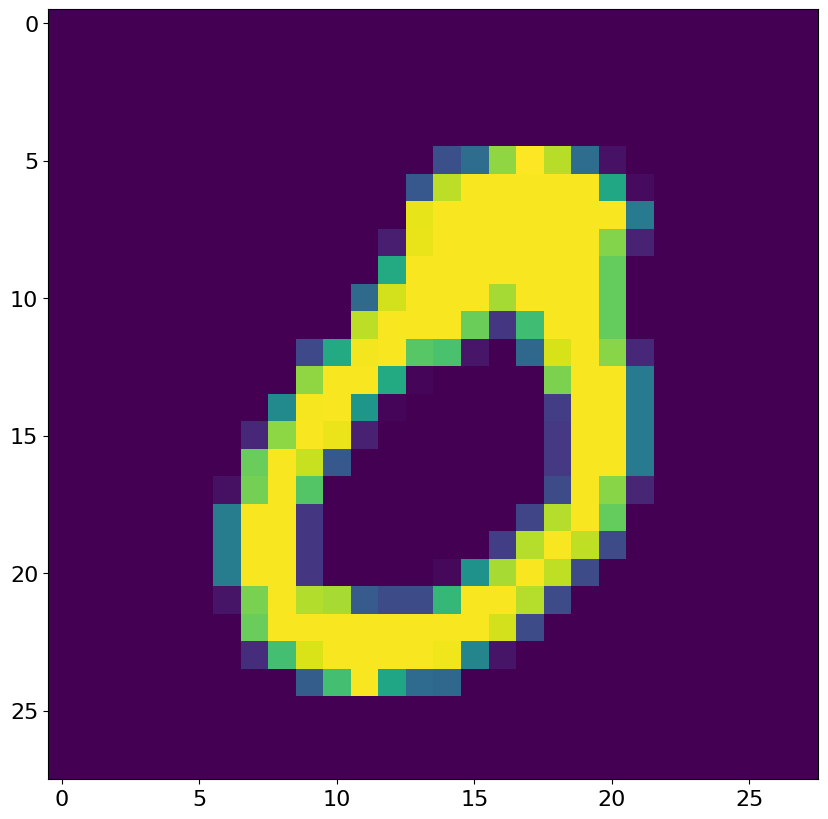

In [ ]:
plt.imshow(x_train[75])


In [ ]:
np.max(x_train[75,:,:])

255

In [47]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [np.linspace(-1, 1, sidelen)])
    mgrid = np.stack(np.meshgrid(*tensors), -1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

pixels=x_train[75,:,:]/255.
coords = get_mgrid(pixels.shape[0], 2)
pixels=pixels.reshape(28*28,1)
coords= coords.reshape(28*28,2)

train_dataset = tf.data.Dataset.from_tensor_slices(( coords, pixels))
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
upCoords=get_mgrid(256, 2)

## Siren

In [48]:

inputs=layers.Input(shape=( 2))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.math.sin)(inputs)
x2=layers.Dense(4, activation=tf.math.sin)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_45 (Dense)            (None, 16)                48        
                                                                 
 dense_46 (Dense)            (None, 4)                 68        
                                                                 
 dense_47 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
mlp.fit(train_dataset, epochs=1000)


Epoch 1/1000
25/25 [==============================] - 1s 3ms/step - loss: 0.2252 - accuracy: 0.4719
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.7628
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1716 - accuracy: 0.7628
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1529 - accuracy: 0.7628
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1399 - accuracy: 0.7628
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.7628
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1269 - accuracy: 0.7628
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1245 - accuracy: 0.7628
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.7628
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1224 - accuracy: 0.7628

In [53]:
pip=mlp.predict(coords)
pipUp=mlp.predict(upCoords)


2048/2048 [==============================] - 3s 1ms/step


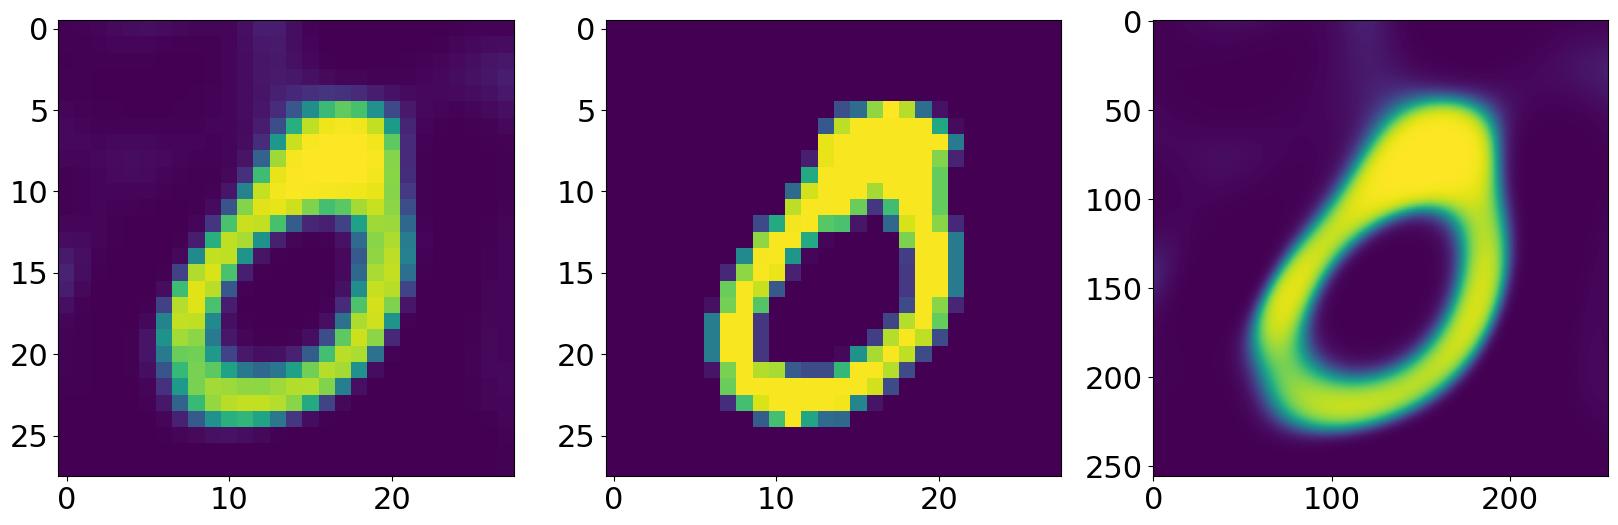

In [54]:
plt.subplot(1,3,1)
plt.imshow(pip.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(pipUp.reshape((256,256)))





## Sinc

In [55]:

inputs=layers.Input(shape=( 2))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation=tf.experimental.numpy.sinc)(inputs)
x2=layers.Dense(4, activation=tf.experimental.numpy.sinc)(x1)
x=layers.Dense(1, activation='sigmoid')(x2)

mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_48 (Dense)            (None, 16)                48        
                                                                 
 dense_49 (Dense)            (None, 4)                 68        
                                                                 
 dense_50 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 1s 3ms/step - loss: 0.1684 - accuracy: 0.7602
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1437 - accuracy: 0.7628
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1322 - accuracy: 0.7628
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1263 - accuracy: 0.7628
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1233 - accuracy: 0.7628
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.7628
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1195 - accuracy: 0.7628
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1182 - accuracy: 0.7628
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1164 - accuracy: 0.7628
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1150 - accuracy: 0.7628

In [57]:
pap=mlp.predict(coords)
papUp=mlp.predict(upCoords)

2048/2048 [==============================] - 3s 1ms/step


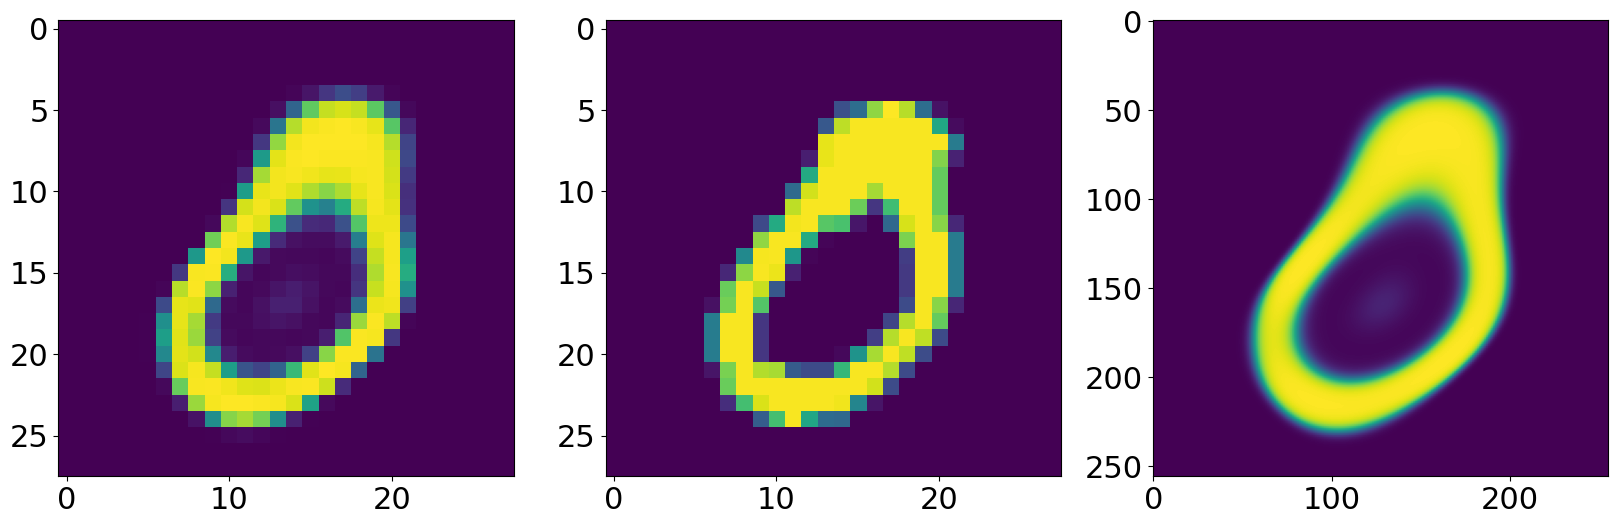

In [58]:
plt.subplot(1,3,1)
plt.imshow(pap.reshape((28,28)))
plt.subplot(1,3,2)
plt.imshow(pixels.reshape((28,28)))
plt.subplot(1,3,3)
plt.imshow(papUp.reshape((256,256)))

## Gelu

In [59]:
inputs=layers.Input(shape=( 2))

 # Define the multilayer perceptron
x1=layers.Dense(16, activation='gelu')(inputs)
x2=layers.Dense(4, activation='gelu')(x1)
x=layers.Dense(1, activation='sigmoid')(x2)


mlp=Model(inputs, x)

 # Compile the model
mlp.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

mlp.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_51 (Dense)            (None, 16)                48        
                                                                 
 dense_52 (Dense)            (None, 4)                 68        
                                                                 
 dense_53 (Dense)            (None, 1)                 5         
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
mlp.fit(train_dataset, epochs=1000)

Epoch 1/1000
25/25 [==============================] - 1s 3ms/step - loss: 0.2299 - accuracy: 0.4401
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.6237
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2052 - accuracy: 0.7577
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.7628
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.7628
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.7628
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.7628
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1577 - accuracy: 0.7628
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1484 - accuracy: 0.7628
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.7628

In [61]:
pop=mlp.predict(coords)


25/25 [==============================] - 0s 2ms/step


25/25 [==============================] - 0s 2ms/step


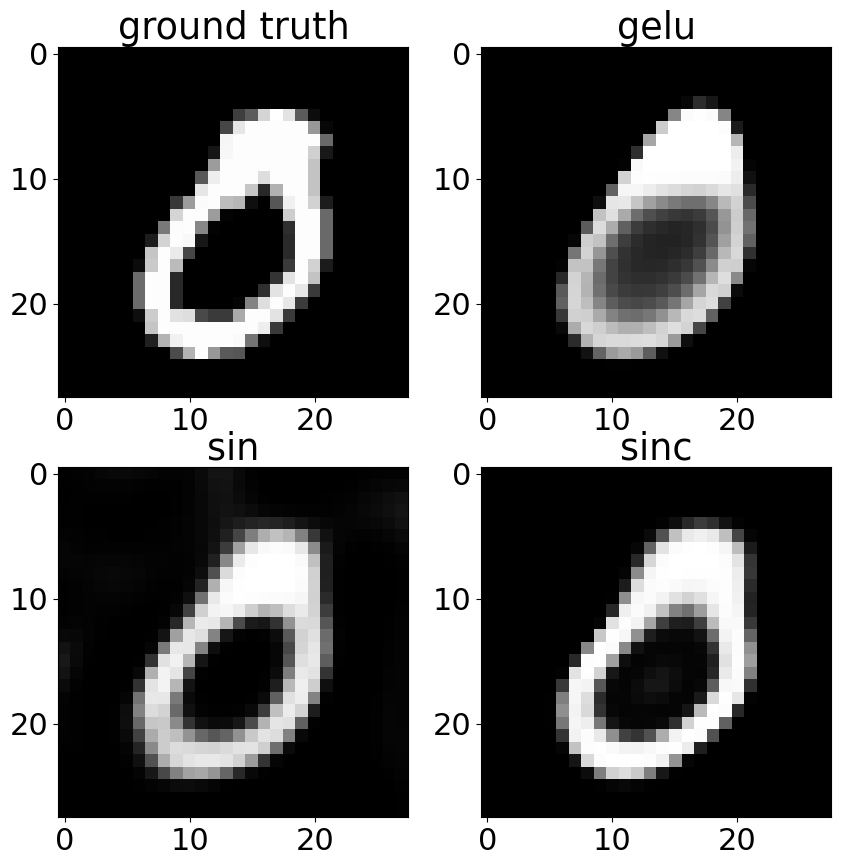

In [64]:
plt.figure(figsize=(10,10))
pop=mlp.predict(coords)
plt.subplot(2,2,1)
plt.imshow(pixels.reshape((28,28)), cmap='gray')
plt.title('ground truth')
plt.subplot(2,2,2)
plt.imshow(pop.reshape((28,28)), cmap='gray')
plt.title('gelu')
plt.subplot(2,2,3)
plt.imshow(pip.reshape((28,28)), cmap='gray')
plt.title('sin')
plt.subplot(2,2,4)
plt.imshow(pap.reshape((28,28)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNR.pdf')



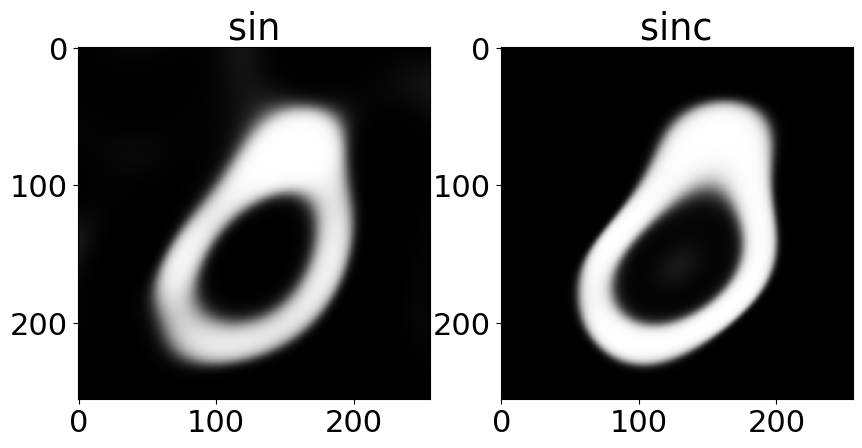

In [66]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(pipUp.reshape((256,256)), cmap='gray')
plt.title('sin')
plt.subplot(1,2,2)
plt.imshow(papUp.reshape((256,256)), cmap='gray')
plt.title('sinc')
plt.savefig('learnedNRup.pdf')